#Projet :
#NLP avec les tweets en cas de catastrophes et événements particuliers : prédire quels tweets concernent de véritables catastrophes et lesquels ne le sont pas

>Par : **KOUHOU Mohamed** 

>Data Engineer INE1


L'objectif de ce projet est de déterminer, parmi un ensemble de tweets, lesquels concernent un catastrophe. Il s'agit donc d'un problème de classification binaire puisqu'il suffit de dire si un tweet parle d'un catastrophe ou pas. Pour cela, nous alons implémenter plusieurs algorithmes de classification pour enfin en choisir le meilleurs que nous utiliserons ensuite pour notre prédiction.
Or, les données, n'étant constituées que du texte, ne peuvent pas être comprises par la machine. C'est ainsi que nous aurons recours à des outils du NLP (Natural Language Processing) pour opérer des transformation sur les données textuelles.

# Importation des bibliothèques et des données

In [ ]:
!pip install nltk

In [ ]:
import numpy as np
import pandas as pd
import warnings
import nltk
warnings.filterwarnings("ignore")

NLTK (Natural Language ToolKit) est une bibliothèque pour la construction de programmes Python destinés à travailler avec des données en langage humain. Elle fournit des interfaces faciles à utiliser pour plus de 50 corpus et ressources lexicales telles que WordNet, ainsi qu'une suite de bibliothèques de traitement de texte pour la classification, la tokenisation, le balisage, l'analyse syntaxique et le raisonnement sémantique.

In [ ]:
train = pd.read_csv('train.csv', index_col = 'id')
test = pd.read_csv('test.csv', index_col = 'id')

#Élimination des colonnes non nécessaires

In [ ]:
train.drop(['keyword','location'], axis = 1, inplace = True)
test.drop(['keyword','location'], axis = 1, inplace = True)

In [ ]:
#Jettons un coup d'oeuil sur la forme des données
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 178.4+ KB


In [ ]:
df_train.head()

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 10875
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3263 non-null   object
dtypes: object(1)
memory usage: 51.0+ KB


In [ ]:
df_test.head()

,text
id,
0,Just happened a terrible car crash
2,"Heard about #earthquake is different cities, s..."
3,"there is a forest fire at spot pond, geese are..."
9,Apocalypse lighting. #Spokane #wildfires
11,Typhoon Soudelor kills 28 in China and Taiwan


Les données d'entraînement sont formées de deux colonnes :


*   text : le texte du tweet
*   target : valeur booléenne indiquant s'il s'agit d'un catastrophe ou pas (1 si oui, 0 si non)

Il s'agit donc bien d'un apprentissage supervisé puisqu'on dispose de données "étiquetées" (labeled data), et les étiquettes ici sont contenues dans la colonne *target*.

Le fichier *test.csv* contient une seule colonne *text*, celle des tweets pour lesquels on souhaite prédire s'il s'agit d'un catastrophe ou non.



# Nettoyage des données

Le nettoyage des données est une étape très cruciale dans tout modèle d'apprentissage de la machine, mais plus encore pour le NLP. Sans le processus de nettoyage, l'ensemble de données est souvent un groupe de mots que l'ordinateur ne comprend pas. 

Pour nettoyer nos données, nous allons éliminer quelques éléments qui sont considérés comme du bruit et qui n'ont aucune valeurs ajoutée (liens, ponctuation, chiffres, caractères spéciaux, mots vides)



In [ ]:
#mettons toutes les données en minuscule
train['text'] = train['text'].apply(lambda x: x.lower())
test['text'] = test['text'].apply(lambda x: x.lower())

In [ ]:
import re
import string
nltk.download("stopwords")
from nltk.corpus import stopwords

for i in range(len(train['text'])):
        # suppression des liens des sites web
        train['text'].iloc[i] = re.sub('www.|https://|http://|.com|t.co/','',train['text'].iloc[i])
        # suppression de la ponctuation 
        train['text'].iloc[i] = ''.join([j for j in train['text'].iloc[i] if j not in string.punctuation])
        # suppression des chiffres
        train['text'].iloc[i] = ''.join([j for j in train['text'].iloc[i] if j not in string.digits])
        # élimination des caractères spéciaux
        train['text'].iloc[i] = ''.join([j for j in train['text'].iloc[i] if ord(j) < 128])
        # élimination des mots vides (stop words)
        train['text'].iloc[i] = ' '.join([j for j in train['text'].iloc[i].split() if j not in stopwords.words('english')])
        
for i in range(len(test['text'])):
        # suppression des liens des sites web
        test['text'].iloc[i] = re.sub('www.|https://|http://|.com|t.co/','',test['text'].iloc[i])
        # suppression de la ponctuation 
        test['text'].iloc[i] = ''.join([j for j in test['text'].iloc[i] if j not in string.punctuation])
        # suppression des chiffres
        test['text'].iloc[i] = ''.join([j for j in test['text'].iloc[i] if j not in string.digits])
        # élimination des caractères spéciaux
        test['text'].iloc[i] = ''.join([j for j in test['text'].iloc[i] if ord(j) < 128])
        # élimination des mots vides (stop words)
        test['text'].iloc[i] = ' '.join([j for j in test['text'].iloc[i].split() if j not in stopwords.words('english')])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Maintenent on dispose de tweets propres sans bruit.

# Tokenisation

La tokenisation est le processus qui consiste à transformer une chaîne de caractères ou un texte en une liste de "tokens". On peut penser à un token comme à des parties, comme un mot est un token dans une phrase, et une phrase est un token dans un paragraphe.

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer= RegexpTokenizer(r'\w+')
train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'].apply(lambda x: tokenizer.tokenize(x))

id
0                         [happened, terrible, car, crash]
2        [heard, earthquake, different, cities, stay, s...
3        [forest, fire, spot, pond, geese, fleeing, acr...
9               [apocalypse, lighting, spokane, wildfires]
11               [typhoon, soudelor, kills, china, taiwan]
                               ...                        
10861    [earthquake, safety, los, angeles, safety, fas...
10865    [storm, ri, worse, last, hurricane, cityampoth...
10868       [green, line, derailment, chicago, utbxlcbiuy]
10874    [meg, issues, hazardous, weather, outlook, hwo...
10875    [cityofcalgary, activated, municipal, emergenc...
Name: text, Length: 3263, dtype: object

# Lemmatisation

La lemmatisation consiste à regrouper  les mots d’une même famille. On parle ici de donner la forme canonique d’un mot ou d’un ensemble de mots : Chacun de ces mots d’un contenu donné se trouve réduit en une entité appelée en lexicologie lemme ou encore “forme canonique d’un mot”

In [ ]:
nltk.download("wordnet")
from nltk.stem import  WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text=[lemmatizer.lemmatize(i,pos="v") for i in text]
    return lem_text
train['text'].apply(lambda x: word_lemmatizer(x))
test['text'].apply(lambda x: word_lemmatizer(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


id
0        [h, a, p, p, e, n, e, d,  , t, e, r, r, i, b, ...
2        [h, e, a, r, d,  , e, a, r, t, h, q, u, a, k, ...
3        [f, o, r, e, s, t,  , f, i, r, e,  , s, p, o, ...
9        [a, p, o, c, a, l, y, p, s, e,  , l, i, g, h, ...
11       [t, y, p, h, o, o, n,  , s, o, u, d, e, l, o, ...
                               ...                        
10861    [e, a, r, t, h, q, u, a, k, e,  , s, a, f, e, ...
10865    [s, t, o, r, m,  , r, i,  , w, o, r, s, e,  , ...
10868    [g, r, e, e, n,  , l, i, n, e,  , d, e, r, a, ...
10874    [m, e, g,  , i, s, s, u, e, s,  , h, a, z, a, ...
10875    [c, i, t, y, o, f, c, a, l, g, a, r, y,  , a, ...
Name: text, Length: 3263, dtype: object

In [ ]:
print(train)
print(train.dtypes)
print(train.shape)

                                                    text  target
id                                                              
1           deeds reason earthquake may allah forgive us       1
4                  forest fire near la ronge sask canada       1
5      residents asked shelter place notified officer...       1
6      people receive wildfires evacuation orders cal...       1
7      got sent photo ruby alaska smoke wildfires pou...       1
...                                                  ...     ...
10869  two giant cranes holding bridge collapse nearb...       1
10870  ariaahrary thetawniest control wild fires cali...       1
10871                     utckm volcano hawaii zdtoydebj       1
10872  police investigating ebike collided car little...       1
10873  latest homes razed northern california wildfir...       1

[7613 rows x 2 columns]
text      object
target     int64
dtype: object
(7613, 2)


In [ ]:
print(test)
print(test.dtypes)
print(test.shape)

                                                    text
id                                                      
0                            happened terrible car crash
2      heard earthquake different cities stay safe ev...
3      forest fire spot pond geese fleeing across str...
9                  apocalypse lighting spokane wildfires
11                   typhoon soudelor kills china taiwan
...                                                  ...
10861  earthquake safety los angeles safety fasteners...
10865  storm ri worse last hurricane cityampothers ha...
10868           green line derailment chicago utbxlcbiuy
10874   meg issues hazardous weather outlook hwo xrbqjhn
10875  cityofcalgary activated municipal emergency pl...

[3263 rows x 1 columns]
text    object
dtype: object
(3263, 1)


In [ ]:
# suppression des espaces de tête
train['text'] = train['text'].apply(lambda x: x.lstrip())
test['text'] = test['text'].apply(lambda x: x.lstrip())

# suppression des espaces à la fin
train['text'] = train['text'].apply(lambda x: x.rstrip())
test['text'] = test['text'].apply(lambda x: x.rstrip())

On sauvegarde les tweets propres dans deux nouveaux fichiers

In [ ]:
train.to_csv('train clean.csv')
test.to_csv('test clean.csv')

# Vectorisation

Après la tokenisation, nos tokens ont besoin d'être encodé en chiffres pour que la machine puisse les comprendre. Ainsi, au lieu de phrases on aura des vecteurs de chiffres, c'est ce qu'on appelle la vectorisation.

Le CountVectorizer de Scikit-learn est utilisé pour convertir une collection de documents textuels en un vecteur contenant le dénombrement des termes/tokens. Il permet également le prétraitement des données textuelles avant de générer la représentation vectorielle.Cette fonctionnalité en fait un module de représentation de caractéristiques très flexible pour le texte.
![example](https://www.educative.io/api/edpresso/shot/5197621598617600/image/6596233398321152)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer()
X_train = CV.fit_transform(train['text'])
Y_train = train['target']

X_test = CV.transform(test['text'])

# Word Cloud

Nous allons visualiser les termes les plus fréquents dans les tweets qui concernent un catastrophe et dans ceux qui ne le concernent pas.

In [ ]:
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'forest fire near la ronge sask canada'

In [ ]:
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'love fruits'

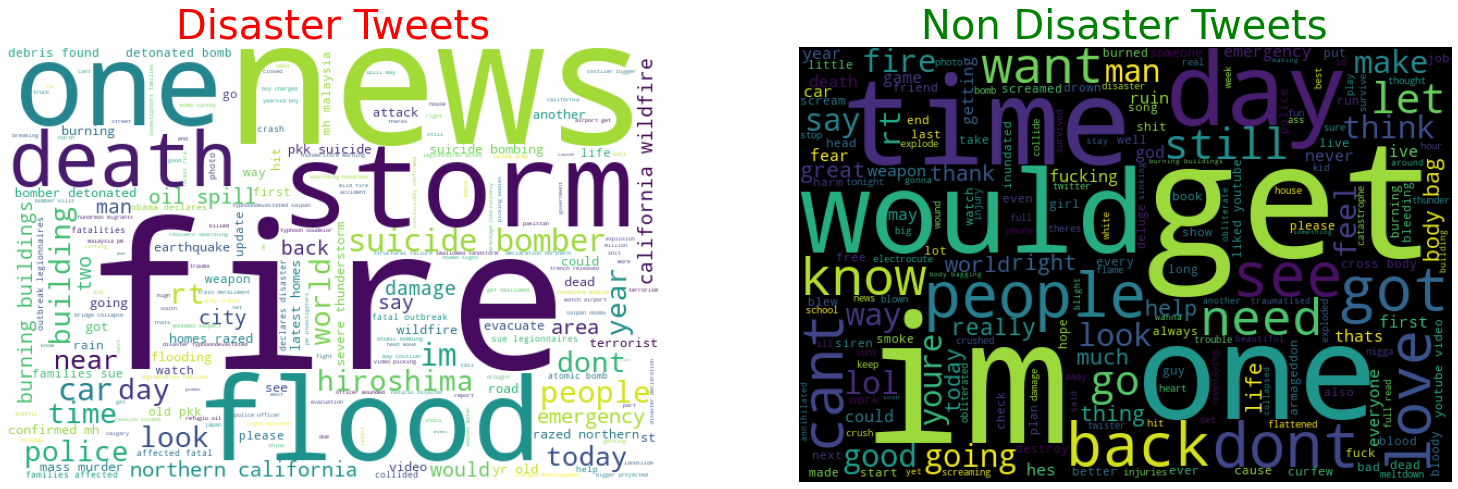

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sw=["new","amp","like","us","via"]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = [26,8])
wordcloud1 = WordCloud(background_color = 'white',stopwords=sw ,width = 600,height = 400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize = 40,color = 'Red');

wordcloud2 = WordCloud(background_color = 'black',stopwords=sw ,width = 600,height = 400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize = 40,color = 'Green');

# Fractionnement de l'ensemble des données

Nous allons réserver 25% de l'ensemble des données pour tester l'efficacité du model

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train,test_size=0.25,random_state=0)

# Procéder à la prédiction

Nous allons tester plusieurs modèles, puis choisir celui qui a le meilleur score sur les données de test

##Les k plus proches voisins (k nearest neighbors)

L'algorithme du plus proche voisin (k-NN) est une méthode non-paramétrique qui - lorsqu'elle est utilisée pour la classification (comme dans notre cas) - donne comme résultat l'appartenance à une classe. Un objet d'entrée est classifié selon le résultat majoritaire des statistiques de classes d'appartenance de ses k plus proches voisins, (k est un nombre entier positif généralement petit). Si $k = 1$, alors l'objet est affecté à la classe d'appartenance de son proche voisin.

Souvent, lorsque l'on parle de voisins les plus proches pour la classification, celle-ci est présentée comme une méthode de boîte noire qui renvoie directement les classifications. Nous allons plutôt l'encadrer comme un modèle non paramétrique pour les probabilités $p_g(x) = P(Y = g \mid X = x)$. C'est un modèle à $k$ voisins les plus proches utilisant $k$ voisins qui estime cette probabilité comme suit :
<h5><center>$\hat{p}_{kg}(x) = \hat{P}_k(Y = g \mid X = x) = \frac{1}{k} \sum_{i \in \mathcal{N}_k(x, \mathcal{D})} I(y_i = g)$!</center></h5>

Ensuite, pour créer un classificateur, il suffit de classer dans la classe dont la probabilité estimée est la plus élevée.

<h5><center>$\hat{C}_k(x) =  \underset{g}{\mathrm{argmax}} \ \ \hat{p}_{kg}(x)$</center></h5>

Dans notre cas, il s'agit d'un classification binaire, ainsi :

<h5><center>$\hat{C}_k(x) = 
\begin{cases} 
      1 & \hat{p}_{k0}(x) > 0.5 \\
      0 & \hat{p}_{k1}(x) < 0.5
\end{cases}$</center></h5>

<center><img src="https://daviddalpiaz.github.io/r4sl/12-knn-class_files/figure-html/unnamed-chunk-1-1.png" width="500"></center>

Voici l'implementation de ce modèle :

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

clf_knn=KNeighborsClassifier(n_neighbors=1)         #construction du classificateur avec n_neighbors : nombre de voisins par défaut
clf_knn.fit(x_train,y_train)                        #entrainement du modèle
knn_pred=clf_knn.predict(x_test)                    #faire la prédiction sur les données de test

cfm_knn=confusion_matrix(y_test,knn_pred)           #Calculer la matrice de confusion pour évaluer la précision de la classification
print(cfm_knn)
Accuracy_knn_train = clf_knn.score(x_train,y_train)
print("score entrainement:-",Accuracy_knn_train)
Accuracy_knn_test = accuracy_score(y_test,knn_pred)
print("score test:-",Accuracy_knn_test)
cv_knn = cross_val_score(clf_knn, x_train, y_train, cv=5)
print("score validation croisee:-",round(cv_knn.mean(), 2) * 100)
print(classification_report(y_test,knn_pred))
knn_pred

[[1017   90]
 [ 444  353]]
score entrainement:- 0.9957961114030478
score test:- 0.7195378151260504
score validation croisee:- 70.0
              precision    recall  f1-score   support

           0       0.70      0.92      0.79      1107
           1       0.80      0.44      0.57       797

    accuracy                           0.72      1904
   macro avg       0.75      0.68      0.68      1904
weighted avg       0.74      0.72      0.70      1904



array([0, 0, 0, ..., 1, 1, 0])

##Forêt d'arbres décisionnels (Random forest classifier)

Les forêts d'arbres décisionnels construisent de nombreux arbres de décision individuels lors de l'entraînement. Les prédictions de tous les arbres sont mises en commun pour faire la prédiction finale (le mode des classes pour la ). Comme elles utilisent un ensemble de résultats pour prendre une décision finale, elles sont appelées techniques d'ensemble.

<center><img src="https://builtin.com/sites/default/files/styles/ckeditor_optimize/public/inline-images/two-tree-random-forest.png" width="500"></center>


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

#contruction du classificateur :
#criterion : fonction permettant de mesurer la qualité d'une scission.
#ici on a pris 'entropy' qui represente le gain d'information.
#n_estimators : le nombre d'arbres
clf_rf=RandomForestClassifier(criterion='entropy',random_state = 0,n_estimators = 30)   
clf_rf.fit(x_train,y_train)
rf_pred=clf_rf.predict(x_test)

cfm_rf=confusion_matrix(y_test,rf_pred)
print(cfm_rf)
Accuracy_rf_train = clf_rf.score(x_train,y_train)
print("score entrainement:-",Accuracy_rf_train)
Accuracy_rf_test = accuracy_score(y_test,rf_pred)
print("score test:-",Accuracy_rf_test)
cv_rf = cross_val_score(clf_rf, x_train, y_train, cv=5)
print("score validation croisee:-",round(cv_rf.mean(), 2) * 100)
print(classification_report(y_test,rf_pred))
rf_pred

[[1037   70]
 [ 305  492]]
score entrainement:- 0.9915922228060956
score test:- 0.803046218487395
score validation croisee:- 78.0
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1107
           1       0.88      0.62      0.72       797

    accuracy                           0.80      1904
   macro avg       0.82      0.78      0.79      1904
weighted avg       0.82      0.80      0.80      1904



array([0, 1, 0, ..., 1, 1, 0])

##Régression logistique (Logistic regression)

La régression logistique binaire estime la probabilité qu'une caractéristique soit présente étant donné les valeurs des variables explicatives, dans ce cas une seule variable catégorielle, dans notre cas il s'agit de la probabilité : 
<center>$\pi_i=P(target_i=1 \mid text_i=x_i)=\dfrac{\text{exp}(\beta_0+\beta_1 x_i)}{1+\text{exp}(\beta_0+\beta_1 x_i)}$</center>

**Estimation des paramètres :**

L'estimateur du maximum de vraisemblance pour les paramètres $\beta_0$ et $\beta_1$ est obtenu en trouvant $\hat{\beta}_0$ et $\hat{\beta}_1$ qui maximisent :
<center>$L(\beta_0,\beta_1)=\prod\limits_{i=1}^N \pi_i^{y_i}(1-\pi_i)^{n_i-y_i}=\prod\limits_{i=1}^N \dfrac{\text{exp}\{y_i(\beta_0+\beta_1 x_i)\}}{1+\text{exp}(\beta_0+\beta_1 x_i)}$</center>

En général, il n'existe pas de solutions formelles. Ainsi, les estimations de MV sont obtenues en utilisant des algorithmes itératifs.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

clf_log=LogisticRegression(random_state=0)
clf_log.fit(x_train,y_train)
log_pred=clf_log.predict(x_test)

cfm_log=confusion_matrix(y_test,log_pred)
print(cfm_log)
Accuracy_log_train = clf_log.score(x_train,y_train)
print("score entrainement:-",Accuracy_log_train)
Accuracy_log_test = accuracy_score(y_test,log_pred)
print("score  test:-",Accuracy_log_test)
cv_log = cross_val_score(clf_log, x_train, y_train, cv=5)
print("score validation croisee:-",round(cv_log.mean(), 2) * 100)
print(classification_report(y_test,log_pred))
log_pred

[[983 124]
 [244 553]]
score entrainement:- 0.9705727798213347
score  test:- 0.8067226890756303
score validation croisee:- 79.0
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1107
           1       0.82      0.69      0.75       797

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.80      1904



array([0, 1, 0, ..., 1, 1, 0])

##Support vector machine(SVM)


Un SVM classifie les données en trouvant le meilleur hyperplan qui sépare tous les points de données d'une classe de ceux de l'autre classe. Le meilleur hyperplan pour un SVM est celui qui présente la plus grande marge entre les deux classes. La marge signifie la largeur maximale de la dalle parallèle à l'hyperplan qui n'a pas de points de données intérieurs.
<center><img src='https://www.researchgate.net/profile/Minghui_Wang15/publication/261154218/figure/fig1/AS:392400972337175@1470567090343/The-support-vector-machine-for-binary-classification.png' width='500'></center>

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

clf_svc=SVC(gamma=0.1)
clf_svc.fit(x_train,y_train)
svc_pred=clf_svc.predict(x_test)

cfm_svc=confusion_matrix(y_test,svc_pred)
print(cfm_svc)
Accuracy_svc_train = clf_svc.score(x_train,y_train)
print("score entrainement:-",Accuracy_svc_train)
Accuracy_svc_test = accuracy_score(y_test,svc_pred)
print("score test:-",Accuracy_svc_test)
cv_svc = cross_val_score(clf_svc, x_train, y_train, cv=5)
print("score validation croisee:-",round(cv_svc.mean(), 2) * 100)
print(classification_report(y_test,svc_pred))
svc_pred

[[1027   80]
 [ 281  516]]
score entrainement:- 0.9560343317568751
score test:- 0.8103991596638656
score validation croisee:- 79.0
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1107
           1       0.87      0.65      0.74       797

    accuracy                           0.81      1904
   macro avg       0.83      0.79      0.80      1904
weighted avg       0.82      0.81      0.80      1904



array([0, 1, 0, ..., 1, 1, 0])

# Choix du meilleur modèle

La matrice de confusion est un tableau qui sert à évaluer la performance d'un modèle de classification :

<center><img src='https://miro.medium.com/max/392/1*YWQM1hy8qGgT1bSpXYnPIg.png'></center>

*   TN = True Negative, c'est-à-dire que lorsque la valeur réelle était "non", le modèle prédisait "non" (prédiction correcte)
*   FP = False Positive, c'est-à-dire que lorsque la valeur réelle était "non", le modèle prédisait "oui" (prédiction erronée)
*   FN = False Negative, c'est-à-dire que lorsque la valeur réelle était "oui", le modèle prédisait "non" (prédiction erronée)
*   TP = True Positive, c'est-à-dire que lorsque la valeur réelle était "oui", le modèle prédisait "oui" (prédiction correcte)

Plusieurs mesures sont considérées pour évaluer la performance d'un modèle, mais donc notre cas on ne va considérer que l' *accuracy* :

<center>$Accuracy = \dfrac{TP + TN}{TP + TN + FP + FN}$</center>

Ainsi on peut choisir le modèle SVM pour notre prédiction.
Nous allons prédire la valeur de *target* pour chacun des tweets contenus dans le fichier *test.csv* et les mettre dans un nouveau fichier *prediction.csv*.






In [ ]:
pred_svc=clf_svc.predict(X_test)

df = pd.DataFrame({'Id':test.index,'text':test.text,'Disaster Tweet':pred_svc})
df['Disaster Tweet'].replace(1, 'Yes',inplace=True)
df['Disaster Tweet'].replace(0, 'No',inplace=True) 

df.to_csv('prediction.csv', index = False)

In [ ]:
df.head()

,Id,text,Disaster Tweet
id,,,
0,0,happened terrible car crash,Yes
2,2,heard earthquake different cities stay safe ev...,No
3,3,forest fire spot pond geese fleeing across str...,Yes
9,9,apocalypse lighting spokane wildfires,No
11,11,typhoon soudelor kills china taiwan,Yes
